# Fast Radio Bursts and Radio Transients from Black Hole Batteries:

#Calculations and Figures

#### Chiara M. F. Mingarelli, chiara@caltech.edu  ---   Last updated 22 September 2015

In [1]:
from __future__ import division
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi
import numpy as np
import statsmodels.api as sm
from scipy.interpolate import interp1d
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text

%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Physical Constants

In [2]:
c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)

## Useful Functions for Gravitational Waves and FRBs

In [3]:
def r_s(m): return 2*G*m/c**2

def mu(m1,m2): return s_mass*(m1*m2)/(m1+m2) # reduced mass

def M(m1,m2): return s_mass*(m1+m2) # total mass

def mchirp(m1,m2): return ((mu(m1,m2))**(3./5))*((M(m1,m2))**(2./5))  # chirp mass

def parsec(d): return d*3.08568025e16/299792458         # converts parsecs to secs

def time(t): return t*299792458/3.08568025e16           # converts light-seconds to parsecs

def years(t): return t*31556926.                        # converts years to seconds

def sec_to_metre(s): return (s*c)                       # input time in seconds

def metre_to_sec(d): return (d/c)                       # distance in metres

def tf(m1,m2,f):
    """
    Calculate time from coalesence at a given frequency
    """
    return -5.*((8*math.pi*f)**(-8./3))*mchirp(m1,m2)**(-5./3)

def freq(t, m1, m2):
    """
    calculate frequency at a time from coalesence
    (note time given should be negative back in time from coalesence)
    """
    return ((1./5.)*(t)*mchirp(m1,m2)**(5./3.))**(-3./8.)*(1./(8.*math.pi))

def separation(m1,m2,time):
    #t_c=488e-6   #time to light ring for canonical values
    t_c=0
    ans = (256./5)**(0.25)*(mu(m1,m2)*M(m1,m2)**2)**(0.25)*(t_c-time)**(0.25)
    return ans

def time_to_coal(r,m1,m2):
    """
    time to coalescence as a function of binary separation r(t)
    and mass components, m1, m2, in units of solar masses
    answer in seconds
    """
    const = 5./256
    ans = (r*s_mass)**4/(mu(m1,m2)*M(m1,m2)**2)
    return ans*const

def lum_frac(mbh, mns, time_step):
    """
    Fractional change in luminosity between time 1 and time 2.
    t_c is the time to coalescence and time 2 is some time 
    Answer is dimensionless
    """
    t_c = time_to_coal(3*mbh,mbh,mns)
    frac = (1-time_step/t_c)
    ans = frac**(-7/4)
    return ans

def burst_Lum(S_nu, dist, freq):
    """
    Input flux in Jansky (Jy), distance in Gpc, frequency in GHz.
    Answer in units of erg/s. This has been double checked.
    """
    ans = 3.35e42*(S_nu/2)*(dist)**2*(freq/1.4)
    return ans

def kepler_f(m1,m2,r):
    """
    orbital frequency from Kepler's 3rd Law
    input r in seconds
    """
    freq = math.sqrt(M(m1,m2))*r**(-3./2)/(2*pi)
    return freq


def luminosity(epsilon, B_0, Mbh, r_sep, r_NS, eff):
    """
    Luminosity of NS before merger with BH. Note that rns and r_sep are in
    units of solar masss, which cancel.
    Epsilon = (rH/(2M))**2; rH=2M is non-spinning, so epsilon=1
    Mbh/r_sep = (v/c*alpha)**2 which is ~1/3
    NS radius, rns, in units of seconds
    This is Eq. 5 of McWilliams and Levin (2011)
    """
    ans = 3e46*eff*epsilon * (Mbh/r_sep) * (B_0/1e12)**2 * (Mbh/10.)**2 *(r_NS*1000/c/(r_sep*s_mass))**6
    #ans = 8*math.pi/epsilon * (B_0*4.5e28)**2 * (Mbh*s_mass)**2
    return ans

def tidal_disrupt(mbh,mns,rns):
    """
    tidal disruption radius of a black hole
    neutron star binary. 
    Input neutron star radius in km.
    Answer in seconds.
    Convert to solar masses by diving my s_mass.
    """
    ans = (mbh/mns)**(1/3)*metre_to_sec(rns*1000)
    return ans

def no_disrupt(mns,rns):
    """
    mass of black hole at which no tidal
    disruption occurs for a given neutron star
    """
    mbh = sqrt(rns**3/(mns*s_mass)/8)
    return mbh

def parkes_noise(Tsys, dish_diam, delta_t, delta_nu):
    Aeff = 0.6*pi*(dish_diam/2)**2
    k=1.38e-23
    radiometer = 2*k*Tsys/Aeff/sqrt(2*delta_nu*delta_t)
    ans = radiometer/1e-26
    return ans 
    
    

## MAIN

In [4]:
    # Physical parameters
    
    epsilon = 1.0  # non-spinning BH
    B_0 = 3e12     # gausss
    Mbh = 10     # solar masses
    Mns = 1.4      # solar masses
    r_NS = 10.0    # km
    LRtime = time_to_coal(30,10,1.4)  # seconds
    steps = 1000
    sep = np.linspace(0.0,70.0, steps)
    longsep = np.linspace(30.0,1000.0, steps)
    mass_range = np.linspace(8.0,32.0, steps)

    # Declaring arrays
    
    lum_vec = np.empty([steps])
    time_to_LR = np.empty([steps])
    time_to_LR_BIGB = np.empty([steps])
    coal_time = np.empty([steps])  
    el_over_el = np.empty([steps])
    el_over_el2 = np.empty([steps])
    el_over_el3 = np.empty([steps])
    mag_test15 = np.empty([steps])
    rel_strength = np.empty([steps])
    
    # Filling arrays
    for k in range (steps):
        # Strong B Field Test
        mag_test15[k] = luminosity(epsilon, 1e15, 10., longsep[k], 10., 1e-2)
        time_to_LR_BIGB[k] = time_to_coal(longsep[k],10,Mns) - LRtime
        # L/L_0 fractions
        el_over_el[k] = lum_frac(mass_range[k], 1.4, -0.5e-3)
        el_over_el2[k] = lum_frac(mass_range[k], 1.4, -1e-3)
        el_over_el3[k] = lum_frac(mass_range[k], 1.4, -5e-3)
        # Battery luminosity for typical parameters
        lum_vec[k] = luminosity(epsilon, 3e12, 10., sep[k], 10., 1e-2) # luminosity(epsilon, B_0, Mbh, r_sep, r_NS, eff)
        time_to_LR[k] = time_to_coal(sep[k],10,Mns) - LRtime
        coal_time[k] = time_to_coal(sep[k],10,Mns)   #time to coalescence 
        rel_strength[k] = lum_frac(10., 1.4, time_to_LR[k])


### Plotting preamble (mostly courtesey of Justin Ellis)

In [5]:
fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
                                'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

#Results

## Figures 1(a) and 1(b)

/Users/chiaramingarelli/env/dev/lib/python2.7/site-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/chiaramingarelli/env/dev/lib/python2.7/site-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/chiaramingarelli/env/dev/lib/python2.7/site-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the sub

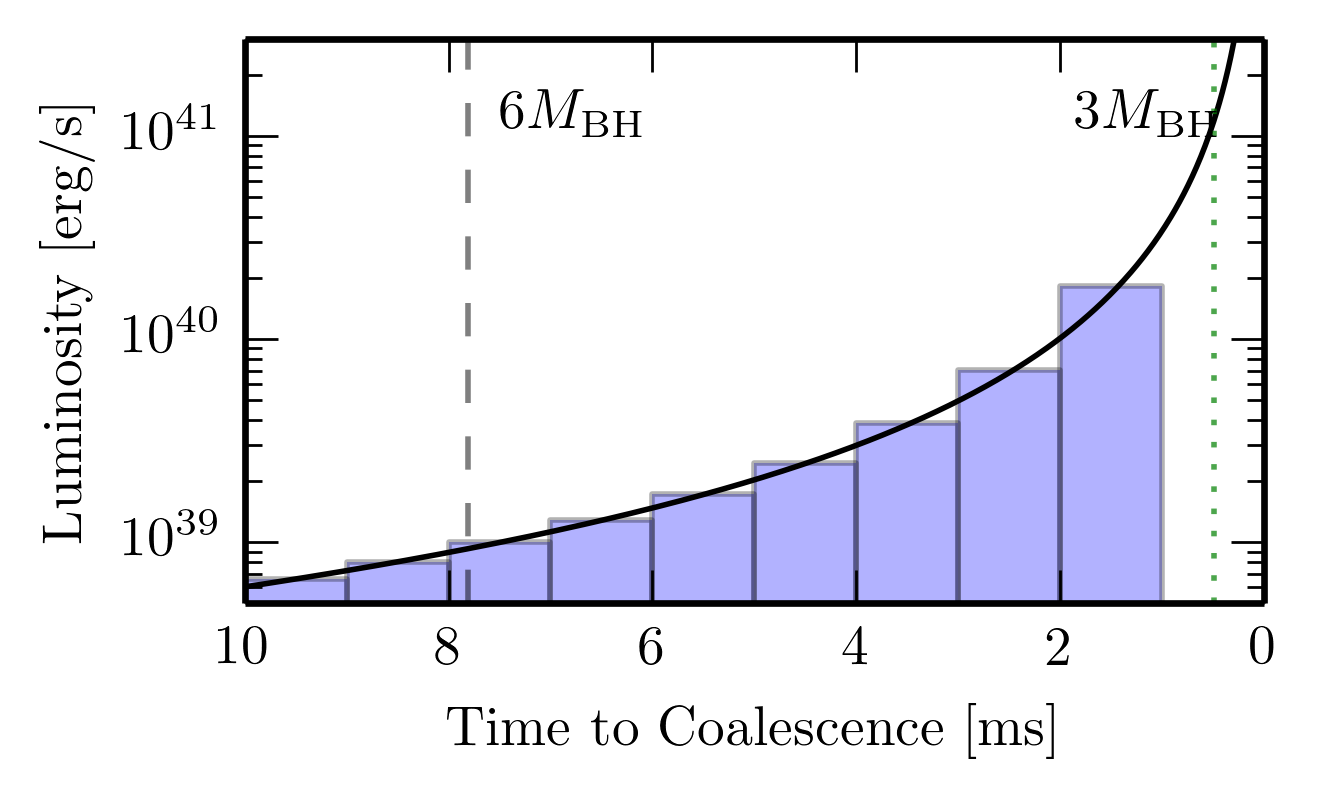

In [6]:
fig=plt.figure()

# axes

ax = fig.add_subplot(111)
#x = (time_to_LR)*1000  # factor of 1,000 for milliseconds
x = coal_time*1000  # factor of 1,000 for milliseconds
y = lum_vec

# bins

bin_width = 1.0 # change this to 0.5 for Figure 1a
xnew = np.arange(x[0], x[-1], bin_width)    
width = (xnew[-1]-xnew[0])/(len(xnew)-1)
f = interp1d(x, y)

# Integrated y-value for bin height
inty = [scipy.integrate.quad(f,a,b)[0] for a,b in zip(xnew[:-1],xnew[1:])]
# inty = [scipy.integrate.quad(f,xnew[i],xnew[i+1])[0] for i in range(len(xnew)-1)]    #alternative to above

# Ramp-up

xs = np.linspace(xnew[0],xnew[-1],1000)
plt.semilogy(xs,f(xs),'black')

# Plot bars

plt.bar(xnew[:-1],inty/width,width=width, alpha=0.3)

# Annotation

plt.axvline(x=0.4883619276333112, color='g', linestyle=":",  alpha=0.7)
plt.annotate(r'$3M_\mathrm{BH}$', xy=(1.85, 1e41), xycoords='data')

plt.axvline(x=7.813790842132979, color='black', linestyle='--', alpha=0.5)
plt.annotate(r'$6M_\mathrm{BH}$', xy=(7.5, 1e41), xycoords='data')

# Axis labels

plt.xlim(0,10)
plt.ylim(5e38, 3e41)
plt.tight_layout()
plt.gca().set_yscale('log',nonposy='clip')
plt.ylabel('Luminosity [erg/s]')
plt.xlabel('Time to Coalescence [ms]')
plt.gca().invert_xaxis()
plt.tight_layout()
#plt.savefig("1ms_bins_with_6M.pdf")
plt.show()



## Figure 1 (d)

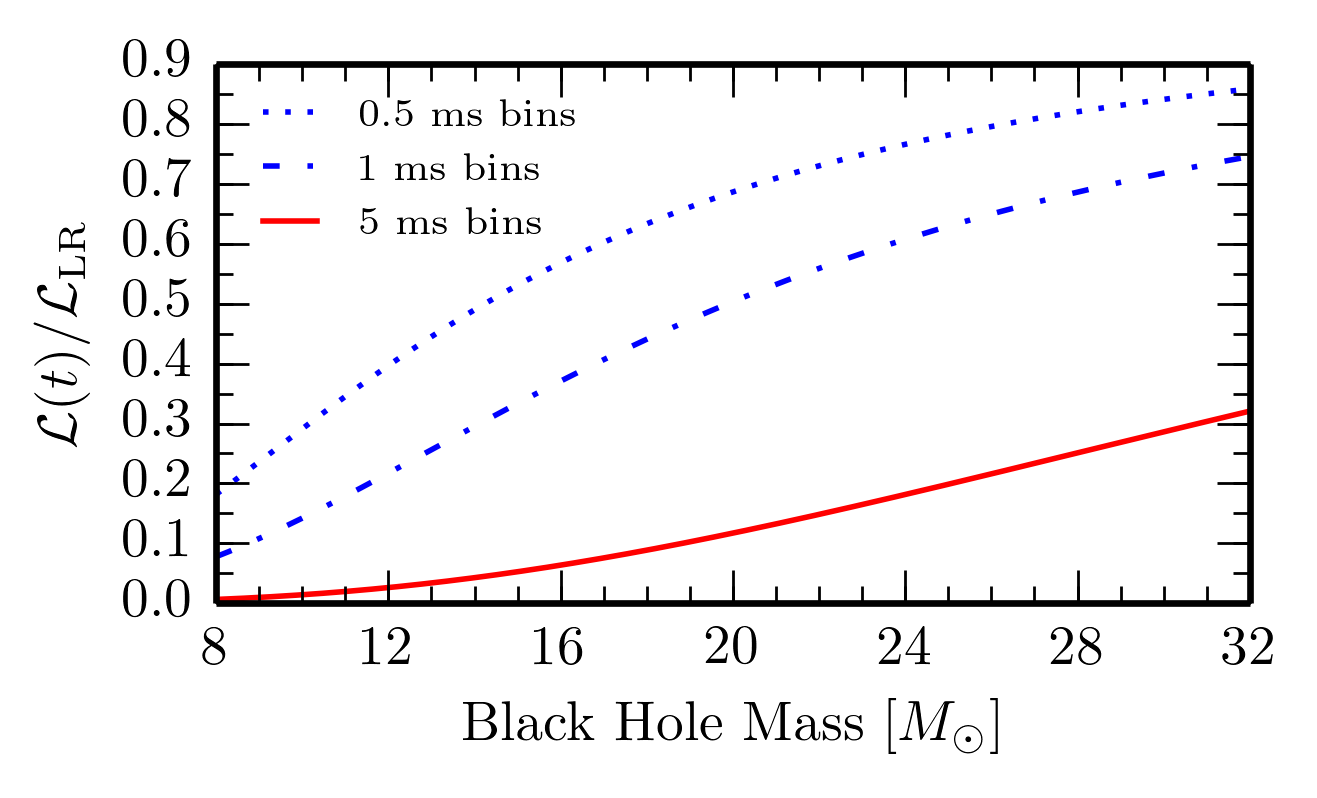

In [7]:
fig, ax= plt.subplots()

# Data to plot

x = mass_range  
y = el_over_el
y2 =el_over_el2
y3 = el_over_el3

# Plotting

plt.plot(x, y, linestyle=':', label=r'0.5~ms bins', color='b')
plt.plot(x, y2, linestyle='-.', label=r'1~ms bins')
plt.plot(x, y3, label=r'5~ms bins', color='r')
plt.xlim(8,32)

# Setting tick sizes

majorLocator   = MultipleLocator(4)
minorLocator   = MultipleLocator(1)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

# Legend and Labels

plt.ylabel(r'$\mathcal{L}(t)/\mathcal{L}_{\mathrm{LR}}$')
plt.xlabel(r'Black Hole Mass $[M_\odot]$')
plt.tight_layout()
plt.legend(loc=2,frameon=False)
#plt.savefig("luminosity_frac.pdf")
plt.show()

## Magnetar with $B=10^{15}$ G, Figure 1(c)

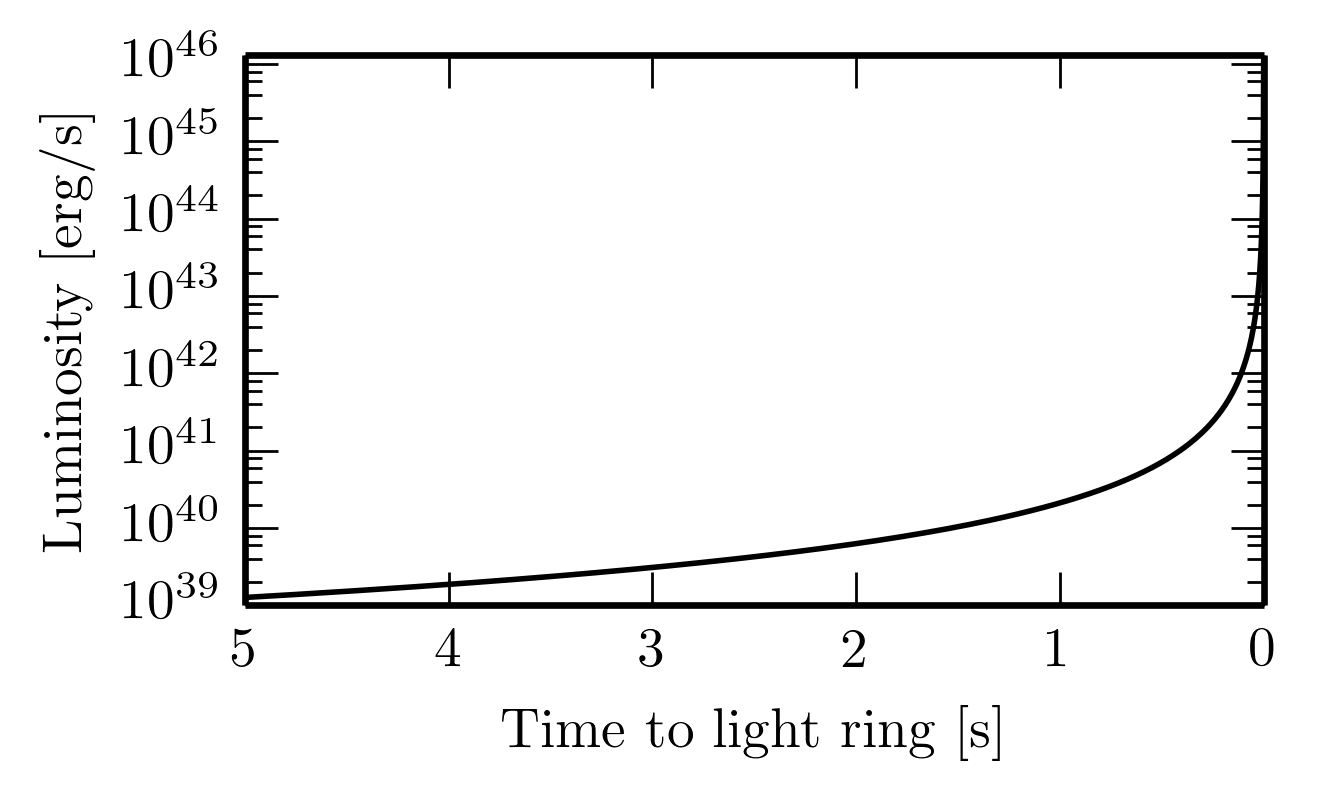

In [8]:
fig=plt.figure()

# axes
ax = fig.add_subplot(111)
y = mag_test15
x = time_to_LR_BIGB

plt.semilogy(x, y, label = r'$r_\mathrm{NS}=10$~km', color = 'black')
plt.xlim(0,5)
plt.ylim(1e39,1.3e46)
ax.set_yscale('log',nonposy='clip')
plt.gca().invert_xaxis()
plt.ylabel('Luminosity [erg/s]')
plt.xlabel(r'Time to light ring [s]')
plt.tight_layout()
#plt.savefig("luminosity_loglog1e15Bfield.pdf")
plt.show()